In [1]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline
import tqdm as notebook_tqdm

import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')
import pdb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

c:\Users\Rodrigo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2018.03.30'
TRAIN_END = '2021.04.05'
TIMES = 10

In [8]:
def create_df(fundo):
    df = pd.read_csv(f'../Data/{fundo}_Daily.csv', sep = "\t")
    df.columns = dfColumns
    df = removeColumns(df, ['tickvol', 'volume','spread'])
    #df = calculateEMA(df,DAYS,newColumns)
    #df = calculateBB(df,DAYS,newColumns)
    df = addPreviousDays(df,DAYS, newColumns)
    initialDf_ = getPeriod(df, '2017.06.01','2021.06.01', True)
    return initialDf_

In [9]:
pd.set_option('display.max_columns', None)
df = create_df('PETR4')

In [5]:
df

,date,open,high,low,close,d-1_open,d-1_high,d-1_low,d-1_close,d-2_open,d-2_high,d-2_low,d-2_close,d-3_open,d-3_high,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2017.06.01,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75,12.29,12.37,12.12,12.12,12.33,12.49,12.29,12.31,12.22,12.51,12.15,12.41,12.67,12.87,12.36,12.46
1,2017.06.02,11.60,11.84,11.50,11.84,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75,12.29,12.37,12.12,12.12,12.33,12.49,12.29,12.31,12.22,12.51,12.15,12.41
2,2017.06.05,11.75,12.01,11.72,11.95,11.60,11.84,11.50,11.84,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75,12.29,12.37,12.12,12.12,12.33,12.49,12.29,12.31
3,2017.06.06,12.00,12.09,11.82,11.95,11.75,12.01,11.72,11.95,11.60,11.84,11.50,11.84,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75,12.29,12.37,12.12,12.12
4,2017.06.07,12.04,12.10,11.62,11.67,12.00,12.09,11.82,11.95,11.75,12.01,11.72,11.95,11.60,11.84,11.50,11.84,11.94,12.05,11.63,11.63,11.98,12.07,11.75,11.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2021.05.26,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93,25.85,26.35,25.80,26.15
984,2021.05.27,26.08,26.25,25.77,25.91,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95,26.15,26.28,25.72,25.93
985,2021.05.28,26.20,27.02,26.15,26.99,26.08,26.25,25.77,25.91,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39,26.08,26.31,25.94,25.95
986,2021.05.31,26.96,27.20,26.78,26.87,26.20,27.02,26.15,26.99,26.08,26.25,25.77,25.91,25.91,26.18,25.65,26.09,26.48,26.62,25.78,25.84,26.28,26.52,25.99,26.39


In [10]:
df.shape

(988, 25)

In [13]:
def exp_chronos(df, target_col='high', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=5):

    # 1. Separar os períodos
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    # 2. Selecionar a série alvo
    y_train = df_train[target_col].values
    y_valid = df_valid[target_col].values
    y_test  = df_test[target_col].values

    # 3. Preparar entrada para Chronos
    serie_torch = torch.tensor(np.concatenate([y_train, y_valid]), dtype=torch.float32)
    
    pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-t5-large", device_map="auto")
    quantiles, mean = pipeline.predict_quantiles(
        context=serie_torch,
        prediction_length=prediction_length,
        quantile_levels=[0.1, 0.5, 0.9]
    )

    #4.Resultados
    y_pred_mean = mean[0].numpy()
    y_test_orig = y_test[-prediction_length:]
    q10 = quantiles[0, :, 0].numpy()
    q90 = quantiles[0, :, 2].numpy()
    uncertainty = q90 - q10


    return [y_test_orig, y_pred_mean, uncertainty]

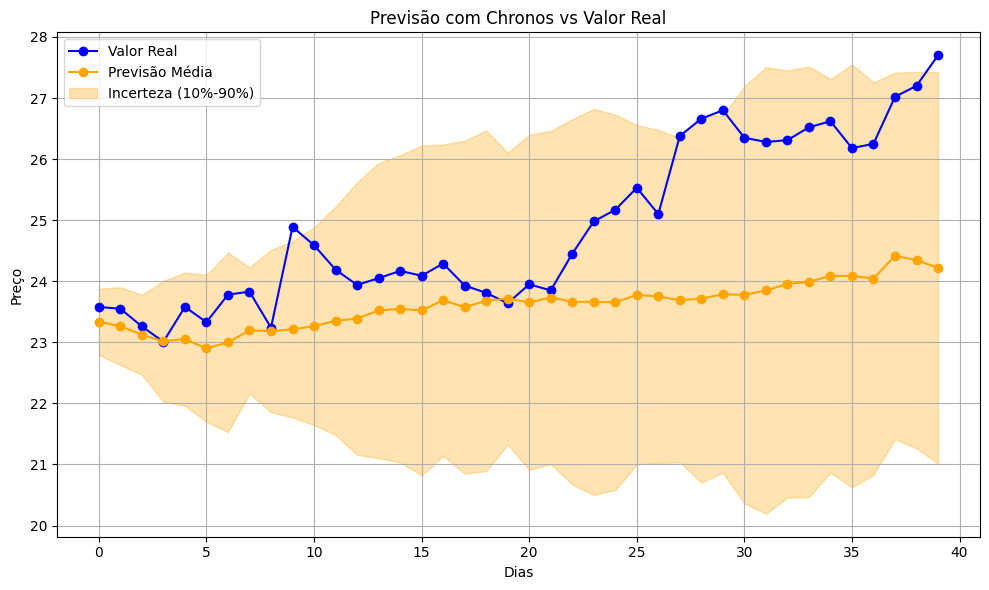

In [14]:
y_test_orig, y_pred_mean, uncertainty = exp_chronos(df, prediction_length=40)

# Criar eixo de tempo
dias = np.arange(len(y_test_orig))

# Calcular faixa de incerteza (intervalo 90% - 10%)
inferior = y_pred_mean - (uncertainty / 2)
superior = y_pred_mean + (uncertainty / 2)

plt.figure(figsize=(10, 6))

# Linha real (azul)
plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

# Linha prevista (laranja)
plt.plot(dias, y_pred_mean, label='Previsão Média', color='orange', marker='o')

# Faixa de incerteza (sombreada)
plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

# Rótulos e legendas
plt.title('Previsão com Chronos vs Valor Real')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Fine tuning?**

In [15]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [16]:
print(df.head(10))

         date   open   high    low  close  d-1_open  d-1_high  d-1_low  \
0  2017.06.01  11.94  12.05  11.63  11.63     11.98     12.07    11.75   
1  2017.06.02  11.60  11.84  11.50  11.84     11.94     12.05    11.63   
2  2017.06.05  11.75  12.01  11.72  11.95     11.60     11.84    11.50   
3  2017.06.06  12.00  12.09  11.82  11.95     11.75     12.01    11.72   
4  2017.06.07  12.04  12.10  11.62  11.67     12.00     12.09    11.82   
5  2017.06.08  11.59  11.75  11.53  11.65     12.04     12.10    11.62   
6  2017.06.09  11.75  11.88  11.64  11.65     11.59     11.75    11.53   
7  2017.06.12  11.76  11.82  11.58  11.70     11.75     11.88    11.64   
8  2017.06.13  11.75  11.81  11.58  11.74     11.76     11.82    11.58   
9  2017.06.14  11.74  11.83  11.44  11.45     11.75     11.81    11.58   

   d-1_close  d-2_open  d-2_high  d-2_low  d-2_close  d-3_open  d-3_high  \
0      11.75     12.29     12.37    12.12      12.12     12.33     12.49   
1      11.63     11.98     12.07 

In [17]:
def getTrainDf(df_train, target_col='high'):
    removed_col = 'low' if target_col == 'high' else 'high'

    df_train = df_train.copy()
    df_train['item_id'] = 'ASSET'
    df_train = df_train.drop([removed_col, 'close'], axis=1)
    df_train = df_train.rename(columns={'date': 'timestamp'})
    df_train.columns = [col for col in df_train.columns]
    return TimeSeriesDataFrame(df_train)

In [18]:
def getTestDf(df):
    df_test = df.copy()
    df_test['item_id'] = 'ASSET'
    df_test = df_test.drop(['high', 'low', 'close'], axis=1)
    df_test = df_test.rename(columns={'date': 'timestamp'})
    df_test.columns = [col for col in df_test.columns]

    return TimeSeriesDataFrame(df_test)


In [19]:
def fixHoliday(df):
    df_ts = df.reset_index()
    nova_linha = df_ts.iloc[10]
    nova_linha['timestamp'] = pd.Timestamp('2021-04-21')
    df_ts = pd.concat([df_ts.iloc[:11], pd.DataFrame([nova_linha]), df_ts.iloc[11:]], ignore_index=True)
    return TimeSeriesDataFrame(df_ts)

In [20]:
def generatePredictor(df, target_col='high', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01',
                prediction_length=41):

    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)

    train_df = getTrainDf(pd.concat([df_train, df_valid]), target_col=target_col)

    predictor = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target=target_col,
        known_covariates_names=[col for col in train_df.columns if col not in ['item_id', 'timestamp', target_col]],
        freq="B"
    ).fit(
        train_df,
        hyperparameters={
            "Chronos": [
                {
                    "model_path": "bolt_small",
                    "covariate_regressor": "CAT",
                    "target_scaler": "standard",
                    "ag_args": {"name_suffix": "WithRegressor"},
                },
            ],
        },
        enable_ensemble=False,
        time_limit=None,
    )

    return predictor
           

In [21]:
def exp_chronos_with_finetuning(df, predictor, target_col='high', normalizer='', 
                train_start='2018.04.02', train_end='2021.02.03',
                valid_start='2021.02.04', valid_end='2021.04.05',
                test_start='2021.04.06', test_end='2021.06.01'):
    
    df_train = getPeriod(df, train_start, train_end)
    df_valid = getPeriod(df, valid_start, valid_end)
    df_test  = getPeriod(df, test_start, test_end)

    y_test  = df_test[target_col].values

    inputDf = getTrainDf(pd.concat([df_train, df_valid]), target_col=target_col)
    covariates_df = getTestDf(df_test)
    covariates_df = fixHoliday(covariates_df)   
    forecast = predictor.predict(inputDf, known_covariates=covariates_df)

    #4.Resultados
    y_pred_mean = forecast['mean']
    y_test_orig = y_test[-40:]
    q10 = forecast['0.1']
    q90 = forecast['0.9']
    uncertainty = q90 - q10


    return [y_test_orig, y_pred_mean, uncertainty]

In [22]:
def generatePlot(df, predictor, target_col): 
    y_test_orig, y_pred_mean, uncertainty = exp_chronos_with_finetuning(df, predictor, target_col=target_col)

    y_pred_mean = y_pred_mean.drop(y_pred_mean.index[11])
    uncertainty = uncertainty.drop(uncertainty.index[11])

    # Criar eixo de tempo
    dias = np.arange(len(y_test_orig))

    # Calcular faixa de incerteza (intervalo 90% - 10%)
    inferior = y_pred_mean - (uncertainty / 2)
    superior = y_pred_mean + (uncertainty / 2)

    plt.figure(figsize=(10, 6))

    # Linha real (azul)
    plt.plot(dias, y_test_orig, label='Valor Real', color='blue', marker='o')

    # Linha prevista (laranja)
    plt.plot(dias, y_pred_mean, label='Previsão Média', color='red', marker='o')

    # Faixa de incerteza (sombreada)
    plt.fill_between(dias, inferior, superior, color='orange', alpha=0.3, label='Incerteza (10%-90%)')

    # Rótulos e legendas
    plt.title('Previsão com Chronos vs Valor Real')
    plt.xlabel('Dias')
    plt.ylabel('Preço (' + target_col + ')')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [23]:
high_predictor = generatePredictor(df, prediction_length=41, target_col='high')

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250609_202503'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       14.22 GB / 31.94 GB (44.5%)
Disk Space Avail:   221.17 GB / 446.38 GB (49.5%)

Fitting with arguments:


{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                            'd-1_low',
                            'd-1_close',
                            'd-2_open',
                            'd-2_high',
                            'd-2_low',
                            'd-2_close',
                            'd-3_open',
                            'd-3_high',
                            'd-3_low',
                            'd-3_close',
                            'd-4_open',
                            'd-4_high',
                            'd-4_low',
                            'd-4

data with frequency 'IRREG' has been resampled to frequency 'B'.


Model not specified in predict, will default to the model with the best validation score: ChronosWithRegressor[bolt_small]


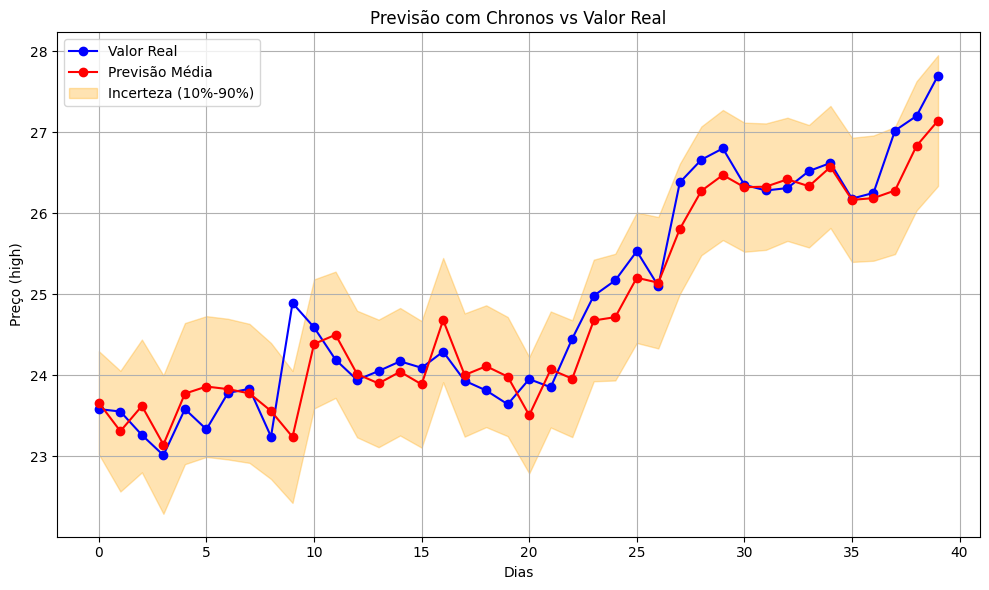

In [24]:
generatePlot(df, high_predictor, 'high')

In [25]:
low_predictor = generatePredictor(df, prediction_length=41, target_col='low')

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250609_202555'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       18.69 GB / 31.94 GB (58.5%)
Disk Space Avail:   221.16 GB / 446.38 GB (49.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

train_data with frequency 'IRREG' has been resampled to frequency 'B'.
Provided train_data has 786 rows (NaN fraction=5.3%), 1 time series. Median time series length is 786 (min=786, max=786). 

Provided data contains following columns:
	target: 'low'
	known_covariates:
		categorical:        []
		continuous (float): ['open', 'd-1_open', 'd-1_high', 'd-1_low', 'd-1_close', 'd-2_open', ...]

To learn how to fix incorrectly inferred types, please see documentation for TimeSeriesPredictor.fit

AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-06-09 17:25:56
Models that will be trained: ['ChronosWithRegressor[bolt_small]']
Training timeseries model ChronosWithRegressor[bolt_small]. 
	-0.0159       = Validation score (-WQL)
	9.86    s     = Training runtime
	1.05    s     = Validation (predi

data with frequency 'IRREG' has been resampled to frequency 'B'.
Model not specified in predict, will default to the model with the best validation score: ChronosWithRegressor[bolt_small]


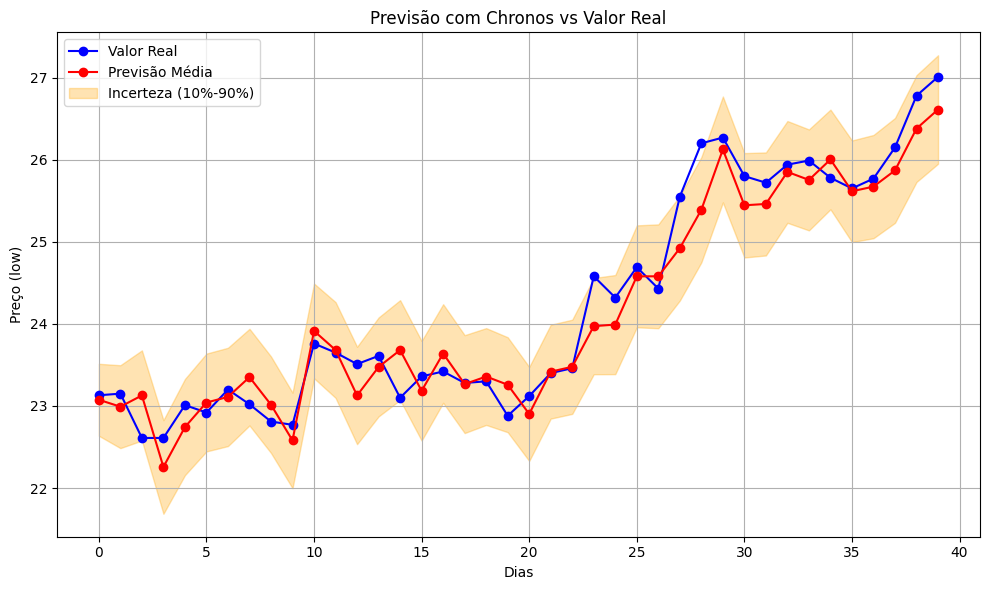

In [26]:
generatePlot(df, low_predictor, 'low')

> Automation

In [40]:
def runPrediction(fundo):
    df = create_df(fundo)

    high_predictor = generatePredictor(df, prediction_length=41, target_col='high')
    low_predictor = generatePredictor(df, prediction_length=41, target_col='low')

    orig_high, pred_high, uncertainty_high = exp_chronos_with_finetuning(df, high_predictor, target_col='high')
    pred_high = pred_high.drop(pred_high.index[11])
    uncertainty_high = uncertainty_high.drop(uncertainty_high.index[11])

    orig_low, pred_low, uncertainty_low = exp_chronos_with_finetuning(df, low_predictor, target_col='low')
    pred_low = pred_low.drop(pred_low.index[11])
    uncertainty_low = uncertainty_low.drop(uncertainty_low.index[11])

    return [orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low]
    

In [44]:
fundos = ['PETR4', 'ABEV3', 'BBDC4', 'EGIE3', 'ITUB4', 'JBSS3', 'VALE3']
for name in fundos:
    orig_high, pred_high, uncertainty_high, orig_low, pred_low, uncertainty_low = runPrediction(name)
    result_prediction = pd.DataFrame()
    #result_prediction['date'] = getPeriod(df, TEST_BEGIN, TEST_END)['date']
    result_prediction['high_pred'] = pred_high
    result_prediction['low_pred'] = pred_low
    result_prediction['uncertainty_high'] = uncertainty_high
    result_prediction['uncertainty_low'] = uncertainty_low
    result_prediction['uncertainty_mean'] = (result_prediction['uncertainty_high'] + result_prediction['uncertainty_low']) / 2
    #result_prediction['uncertainty_valid_mean'] = (f[:,0] + f[:,1]) / 2
    result_prediction['high'] = orig_high
    result_prediction['low'] = orig_low
    result_prediction.to_pickle(f'../Data/{name}_Pred.pkl')
    result_prediction.tail(10)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\Rodrigo\Desktop\TCC\Code\DayTradeSystem\DayTradeSystem\Rodrigo\AutogluonModels\ag-20250609_204833'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       18.04 GB / 31.94 GB (56.5%)
Disk Space Avail:   221.09 GB / 446.38 GB (49.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'bolt_small',
                                  'target_scaler': 'standard'}]},
 'known_covariates_names': ['open',
                            'd-1_open',
                            'd-1_high',
                      

In [48]:
pred_PETR4 = pd.read_pickle('../Data/ABEV3_Pred.pkl')
pred_PETR4 = pred_PETR4.reset_index()
pred_PETR4

,item_id,timestamp,high_pred,low_pred,uncertainty_high,uncertainty_low,uncertainty_mean,high,low
0,ASSET,2021-04-06,14.952989,14.630005,0.420668,0.322286,0.371477,14.97,14.66
1,ASSET,2021-04-07,14.933817,14.641156,0.475090,0.360454,0.417772,14.92,14.59
2,ASSET,2021-04-08,14.988503,14.626554,0.496156,0.374112,0.435134,15.15,14.64
3,ASSET,2021-04-09,15.059850,14.668490,0.500221,0.380292,0.440257,15.12,14.71
4,ASSET,2021-04-12,15.075702,14.701956,0.497167,0.381842,0.439505,15.08,14.85
5,ASSET,2021-04-13,15.149243,14.737449,0.490144,0.385193,0.437668,15.22,14.86
6,ASSET,2021-04-14,15.312494,14.906201,0.485686,0.388964,0.437325,15.37,15.10
7,ASSET,2021-04-15,15.400003,15.000896,0.479340,0.388009,0.433674,15.50,15.20
8,ASSET,2021-04-16,15.448181,15.081767,0.472025,0.387888,0.429956,15.43,15.20
9,ASSET,2021-04-19,15.315485,15.027051,0.465313,0.387963,0.426638,15.54,15.00
